# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [8]:
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

import check_test
from plot_utils import plot_values

Create an instance of the `CliffWalking` environment

In [5]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [6]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'fal

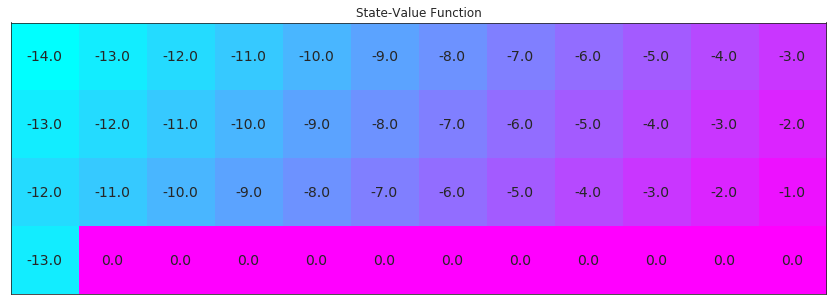

In [7]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa (`Sarsa(0)`)

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.


_**Notes for myself**: In my initial implementation, I didn't differenciate the case where next state is None (i.e., current state is the terminate state)._


In [60]:
def sarsa(env, num_episodes, alpha=0.02, gamma=1,
          epsilon_init=1, epsilon_decay=0.999, epsilon_min=0.00001):

    Q = defaultdict(lambda: [0] * env.action_space.n)
    epsilon = epsilon_init

    for i in range(1, num_episodes + 1):
        if i % 100 == 0:
            print(f'\rEpisode: {i}/{num_episodes}.', end='')
            sys.stdout.flush()

        run_episode_with_sarsa(env, Q, alpha, gamma, epsilon)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

    return Q


def run_episode_with_sarsa(env, Q, alpha, gamma, epsilon):
    state = env.reset()
    action = pick_action_using_epsilon_greedy(Q, state, epsilon)
    
    for _ in range(500):  # limit steps to prevent too long episode
        new_state, reward, done, info = env.step(action)
        
        if not done:
            new_action = pick_action_using_epsilon_greedy(Q, new_state, epsilon)
            update_Q_sarsa(Q, state, action, reward, new_state, new_action, alpha, gamma)
            state, action = new_state, new_action
        else:
            update_Q_sarsa(Q, state, action, reward, None, None, alpha, gamma)
            return


def pick_action_using_epsilon_greedy(Q, state, epsilon):
    action_values = Q[state]
    if np.random.random_sample() > epsilon:
        return np.argmax(action_values)
    else:
        return np.random.choice(list(range(len(action_values))))

    
def update_Q_sarsa(Q, state, action, reward, new_state, new_action, alpha, gamma):
    # Have to use `if new_state is not None` instead of `if new_state`
    q_of_new_state_action_pair = Q[new_state][new_action] if new_state is not None else 0
    approx_return = reward + gamma * q_of_new_state_action_pair
    Q[state][action] = Q[state][action] + alpha * (approx_return - Q[state][action])
    return


Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode: 5000/5000.

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  2  0  1  3  3  1  3  1  1  1  2]
 [ 0  1  1  0  3  2  1  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'fal

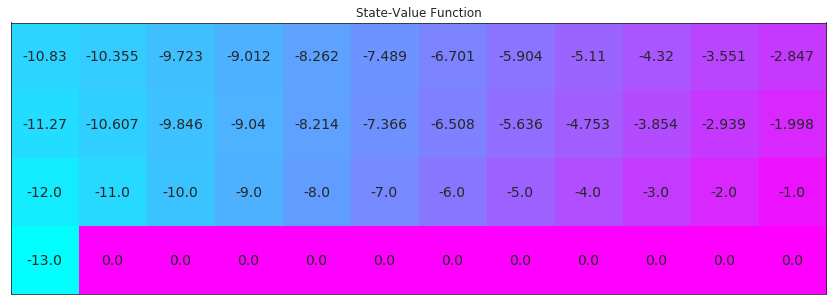

In [61]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01, epsilon_decay=0.5)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [72]:
def q_learning(env, num_episodes, alpha, gamma=1,
               epsilon_init=1.0, epsilon_decay=0.999, epsilon_min=0.00001):
    
    Q = defaultdict(lambda: [0] * env.action_space.n)
    epsilon = epsilon_init
    
    for i in range(1, num_episodes+1):
        if i % 100 == 0:
            print(f'\rEpisode {i}/{num_episodes}.', end='')
            sys.stdout.flush()
        
        run_episode_with_q_learning(env, Q, alpha, gamma, epsilon)
        epsilon = min(epsilon * epsilon_decay, epsilon_min)
    
    return Q


def run_episode_with_q_learning(env, Q, alpha, gamma, epsilon):
    state = env.reset()
    
    for _ in range(500):  # limit steps in each episode
        action = pick_action_using_epsilon_greedy(Q, state, epsilon)
        new_state, reward, done, info = env.step(action)
        
        if not done:
            update_Q_using_q_learning(Q, state, action, reward, new_state, alpha, gamma)
            state = new_state
        else:
            update_Q_using_q_learning(Q, state, action, reward, None, alpha, gamma)
            return


def update_Q_using_q_learning(Q, state, action, reward, new_state, alpha, gamma):
    max_q = max(Q[new_state]) if new_state is not None else 0
    approx_return = reward + gamma * max_q
    Q[state][action] += alpha * (approx_return - Q[state][action])
    return

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 3000/3000.

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  2  1  1  1  3  3  2  2]
 [ 1  0  1  0  2  0  1  1  2  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'fal

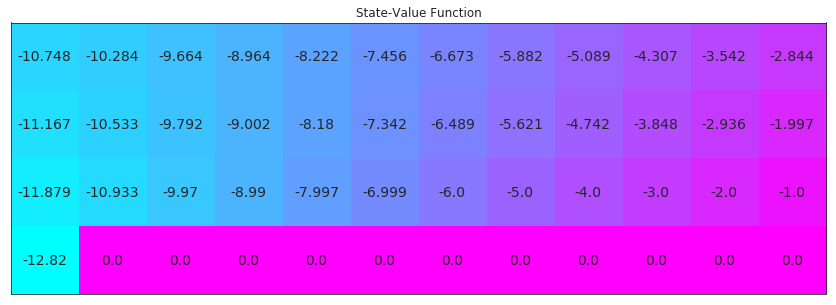

In [83]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 3000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [120]:
def expected_sarsa(env, num_episodes, alpha, gamma=1,
                   epsilon_init=1, epsilon_decay=0.99, epsilon_min=0.00001):
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    epsilon = epsilon_init
    
    for i in range(1, num_episodes+1):
        if i % 100 == 0:
            print(f'\rEpisode {i}/{num_episodes}', end='')
            sys.stdout.flush()
        
        run_episode_with_expected_sarsa(env, Q, alpha, gamma, epsilon)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
    
    return Q


def run_episode_with_expected_sarsa(env, Q, alpha, gamma, epsilon):
    state = env.reset()
    
    while True:
        action = pick_action_using_epsilon_greedy(Q, state, epsilon)
        new_state, reward, done, info = env.step(action)
        
        if not done:
            update_Q_using_expected_sarsa(Q, state, action, reward, new_state,
                                          alpha, gamma, epsilon)
            state = new_state
        else:
            update_Q_using_expected_sarsa(Q, state, action, reward, None,
                                          alpha, gamma, None)
            return


def update_Q_using_expected_sarsa(Q, state, action, reward, new_state,
                                  alpha, gamma, epsilon):
    expected_q = calculate_expected_q(Q, new_state, epsilon) if new_state is not None else 0
    approx_return = reward + gamma * expected_q
    Q[state][action] += alpha * (approx_return - Q[state][action])
    return


def calculate_expected_q(Q, new_state, epsilon):
    action_values = Q[new_state]
    best_action = np.argmax(action_values)
    p = np.full(action_values.shape, epsilon / len(action_values))
    p[best_action] += (1 - epsilon)
    return sum(action_values * p)

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

_**Notes for myself**: in first trial, I used epsilon_init of 1.0. However the model failed to pass the test after 10k episodes. After adjusting epsilon_init to 0.005, it was able to learn successfully_

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  2  0  2  1  1  1  0  1  2]
 [ 1  3  1  2  1  0  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/jibin/miniconda3/envs/reinforcement-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'fal

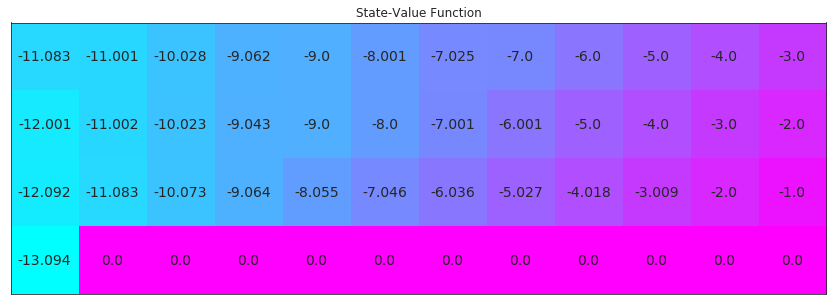

In [134]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 35, 1, epsilon_init=0.0005)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])